### Machine-Learning Asset Allocation

Most of the functions below can be found under:

* Portfolio_opt/**

This exercise is not part of AFML syllabus, but forms part of portfolio optimization series.

The focused optimization technique will be Nested Clustered Optimization (NCO), which has to be combined with other portfolio management style to form a complete picture.

There are 2 other techniques available; Minimize Variance (IVP) and Maximize Returns.

For simplicity, the exercise will minimize variance only instead of return maximization.

Like HRP, this technique requires large investment universe or AUM estimated (> 350 millions at least) to implement.

There will be 2 innovations to this method.
1. Solving convex optimization problems, while controlling for instabilities caused by input noise and complex signal structure
2. Evaluate the estimation error associated with a variety of optimization approaches

If you are keen on generating synthetic data for your research, copy the code snippets [Generate synthetic raw data](https://gist.github.com/boyboi86/5e00faf48f60abfdbe838fbdee269471) in my gist.

Additional resource: 
* [Critical Line Aglorithm](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2197616)
* [Efficient Frontier Robust Estimator](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3469961)
* [ML Asset Allocation](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3469964)
* [Detection of False Investment Strategies Using Unsupervised Learning Methods](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3167017)
* [Estimation of Implied-Correlation Matrix](https://poseidon01.ssrn.com/delivery.php?ID=777119081090115114117002126067074029117046025068004010066117097028007110104100113119029035055009008044005105102126124025012120106071060023014122071102065110095077066011054101118071118101024105021102075086098114101095105016028088066084075003091083020&EXT=pdf)

Contact: boyboi86@gmail.com

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import research as rs
from scipy.linalg import block_diag

%matplotlib inline

Num of CPU core:  4
Machine info:  Windows-10-10.0.18362-SP0
Python 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Numpy 1.18.5
Pandas 1.0.4


In [2]:
def corr_mtx_plot(corr: float, path: str = None, labels = None, title = None):
    plt.figure(figsize=(8,6))
    if labels is None: 
        labels = []
    plt.pcolor(corr)
    plt.colorbar()
    plt.yticks(np.arange(.5, corr.shape[0] + .5), labels)
    plt.xticks(np.arange(.5, corr.shape[0] + .5), labels)
    if path is not None:
        plt.savefig(path)
        plt.clf()
        plt.close()
    if title is not None:
        plt.title(title)
    plt.show()

def corr2cov(corr,std):
    cov=corr*np.outer(std,std)
    return cov

#------------------------------------------------------------------------------
def formBlockMatrix(nBlocks,bSize,bCorr):
    block=np.ones((bSize,bSize))*bCorr
    block[range(bSize),range(bSize)]=1
    corr=block_diag(*([block]*nBlocks))
    return corr
#------------------------------------------------------------------------------
def formTrueMatrix(nBlocks,bSize,bCorr,std0=None):
    corr0=formBlockMatrix(nBlocks,bSize,bCorr)
    corr0=pd.DataFrame(corr0)
    corr_mtx_plot(corr = corr0, title = "Correlation Matrix Heat-Map")
    cols=corr0.columns.tolist()
    np.random.shuffle(cols) #this portion is actually not necessary for this example
    corr0=corr0[cols].loc[cols].copy(deep=True)
    if std0 is None:std0=np.random.uniform(.05,.2,corr0.shape[0])
    else:std0=np.array([std0]*corr0.shape[1])
    cov0=corr2cov(corr0,std0)
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1)
    return mu0,cov0

#=======================================================
def create_true_mtx(nBlocks: int = 10, bSize: int = 5, bCorr: float = .5, seed: int = 0):
    np.random.seed(seed)
    mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)
    return mu0, cov0

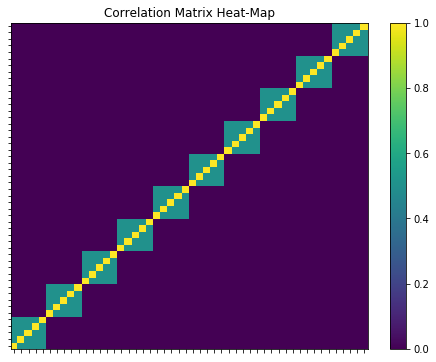

In [3]:
ave_return, cov0 = create_true_mtx(nBlocks = 10, bSize = 5, bCorr = .5, seed = 0)

**Note**

The above Heat-Map reflects Correlation Matrix based on the synthetic data generated.

We can resample to a lower frequency (From daily to weekly) to improve the heat map distribution. [AFML 16.1](https://github.com/boyboi86/AFML/blob/master/AFML%2016.1.ipynb)

Comparing the above matrix to HRP's. It seems that the above has went through quasi-diagonization.

**Note**

If you feed the algorithm with sub-zero numbers, it will prompt errors. Alot of times.

For now, we can still "cheat".

Convexity optimization byitself is supposed to be a "long" technique.

Adjustments will be necessary if bi-directional approach were used.

**Note**

Moreover, we are only using 50 assets which is considered very small.

**Note**

Threshold is automatically set at 0.00001

In [4]:
import warnings
warnings.filterwarnings(action = "ignore",
                        category=RuntimeWarning) # too annoying

w0, w1, w1_d, err, err_d = rs.NCO(mu0 = ave_return,
                                 cov0 = cov0).solve( n_runs = 30,
                                                     bWidth = .25,
                                                     minVarPortf = True,
                                                     shrink = False)

def report_(allocation):
    tw = allocation["True Weights"].mul(allocation["Average Return"]) * 10
    cvo = allocation["Covexity-Optimized Weights"].mul(allocation["Average Return"]) * 10
    nco  = allocation["Nested-Cluster Weights"].mul(allocation["Average Return"]) * 10
    er0, std0 = np.sum(tw), np.std(tw)
    er1, std1 = np.sum(cvo), np.std(cvo)
    er2, std2 = np.sum(nco), np.std(nco)
    print("\nExpected Return\n{0}\nTrue Weights: {1:.3f}".format("=" * 33, er0))
    print("Covexity-Optimized Weights: {0:.3f}".format(er1))
    print("Nested-Cluster Weights: {0:.3f}".format(er2))
    
    print("\nStandard Deviation\n{0}\nTrue Weights: {1:.5f}".format("=" * 33, std0))
    print("Covexity-Optimized Weights: {0:.5f}".format(std1))
    print("Nested-Cluster Weights: {0:.5f}".format(std2))

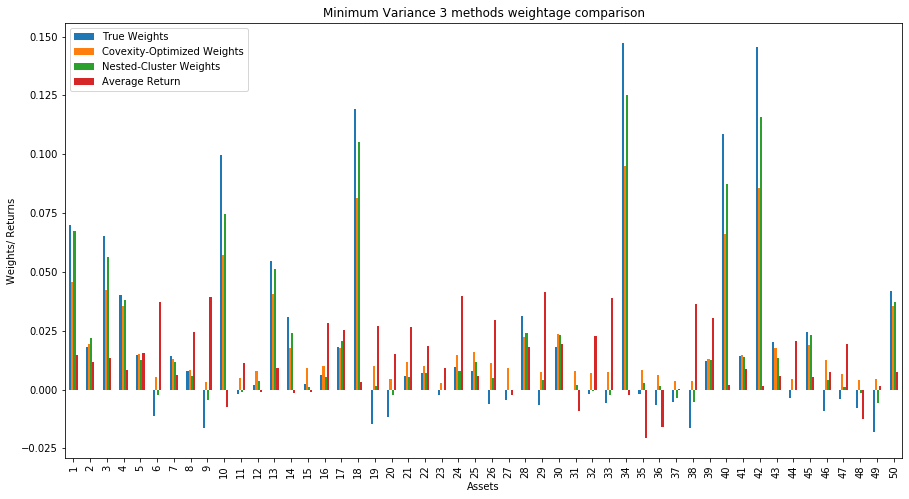

MSE CVO: 0.010
MSE NCO: 0.010

Total Allocation
TW: 1.000
CVO: 1.000
NCO: 1.000

Expected Return
True Weights: 0.035
Covexity-Optimized Weights: 0.081
Nested-Cluster Weights: 0.059

Standard Deviation
True Weights: 0.00331
Covexity-Optimized Weights: 0.00206
Nested-Cluster Weights: 0.00248


In [5]:
allocation = pd.DataFrame({"True Weights":w0[0], 
                           "Covexity-Optimized Weights": w1.mean(), 
                           "Nested-Cluster Weights": w1_d.mean(), 
                           "Average Return": ave_return.flatten() * 0.1}) #if not value too large

allocation.index = np.arange(1,51)
allocation.plot.bar(figsize=(15,8))
plt.title("Minimum Variance 3 methods weightage comparison")
plt.xlabel("Assets")
plt.ylabel("Weights/ Returns")
plt.show()

print("MSE CVO: {0:.3f}\nMSE NCO: {0:.3f}".format(err, err_d))
print("\nTotal Allocation\nTW: {0:.3f}\nCVO: {1:.3f}\nNCO: {2:.3f}".format(w0[0].sum(),
                                                                           w1.mean().sum(),
                                                                           w1_d.mean().sum()))

report_(allocation)

### NCO vs CVO vs True Weights

True Weights is mostly leader in all techniques.

In most if not all cases, where NCO is higher than CVO weightage. True weight will become the "leader".

**Note**

Total allocation for NCO and True weight is 1. This is not correct.

By right, allocation must be within range (0,1). Given the fact we are assigning negative weights.

Total allocation must be 0. In the event if bi-directional portfolio is applied. There will be a need to adjust the weights to tally.

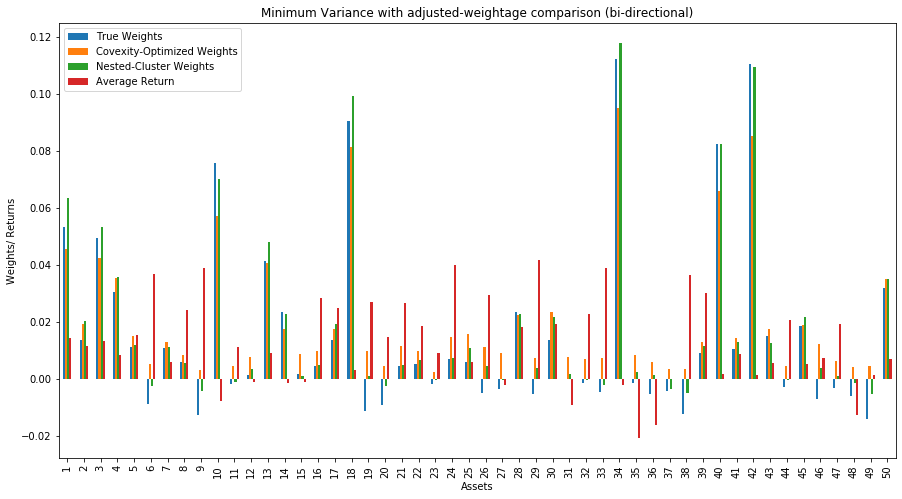


Total Allocation
TW: 0.762
CVO: 1.000
NCO: 0.944

Expected Return
True Weights: 0.026
Covexity-Optimized Weights: 0.081
Nested-Cluster Weights: 0.056

Standard Deviation
True Weights: 0.00252
Covexity-Optimized Weights: 0.00206
Nested-Cluster Weights: 0.00234


In [6]:

sum0 = np.absolute(w0[0]).sum()
sum1 = np.absolute(w1_d.mean()).sum()
allocation["True Weights"] = allocation["True Weights"].div(sum0)
allocation["Nested-Cluster Weights"] = allocation["Nested-Cluster Weights"].div(sum1)

allocation.plot.bar(figsize=(15,8))
plt.title("Minimum Variance with adjusted-weightage comparison (bi-directional)")
plt.xlabel("Assets")
plt.ylabel("Weights/ Returns")
plt.show()

print("\nTotal Allocation\nTW: {0:.3f}\nCVO: {1:.3f}\nNCO: {2:.3f}".format(allocation["True Weights"].sum(),
                                                                           w1.mean().sum(),
                                                                           allocation["Nested-Cluster Weights"].sum()))


report_(allocation)

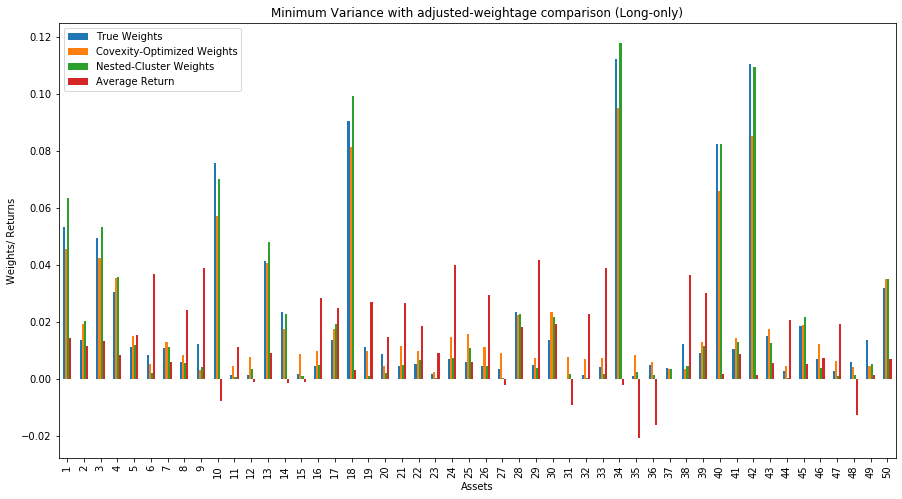


Total Allocation
TW: 1.000
CVO: 1.000
NCO: 1.000

Expected Return
True Weights: 0.072
Covexity-Optimized Weights: 0.081
Nested-Cluster Weights: 0.067

Standard Deviation
True Weights: 0.00213
Covexity-Optimized Weights: 0.00206
Nested-Cluster Weights: 0.00222


In [7]:
allocation = allocation.apply(lambda x: np.absolute(x))
allocation["Average Return"] = ave_return.flatten() * 0.1
allocation.plot.bar(figsize=(15,8))
plt.title("Minimum Variance with adjusted-weightage comparison (Long-only)")
plt.xlabel("Assets")
plt.ylabel("Weights/ Returns")
plt.show()

print("\nTotal Allocation\nTW: {0:.3f}\nCVO: {1:.3f}\nNCO: {2:.3f}".format(allocation["True Weights"].sum(),
                                                                           w1.mean().sum(),
                                                                           allocation["Nested-Cluster Weights"].sum()))
    
report_(allocation)

### Conclusion

In the event where it is necessary to feed sub-returns, make sure you adjust the weights.

The True weight allocation will produce the second highest return and standard deviation.

Which Is the sweet spot between hierachical cluster (Correlation-minimization) and convexity optimization (Returns-maximization).

In short:

* The De-noising algorithm calculates the eigenvalues of the correlation matrix and eliminates the ones that are higher than the theoretically estimated ones, as they are caused by noise.
* The Convex Optimization Solution (CVO) can either find optimal allocations for maximum Sharpe ratio or minimum variance.
* The Nested Clustered Optimization (NCO) breaks the correlation matrix into clusters and applies CVO individually to each cluster as well as to the correlation matrix where each element represents a cluster.
* The Monte Carlo Optimization Selection (MCOS) allows running optimization methods (in our case CVO and NCO) on multiple sets of empirical covariation matrices and empirical vectors of means. It can show which method is more robust.

**Note**

If you notice the below graphs contains strong resemblance in weight assignment to the HRP graph. (Right to left)

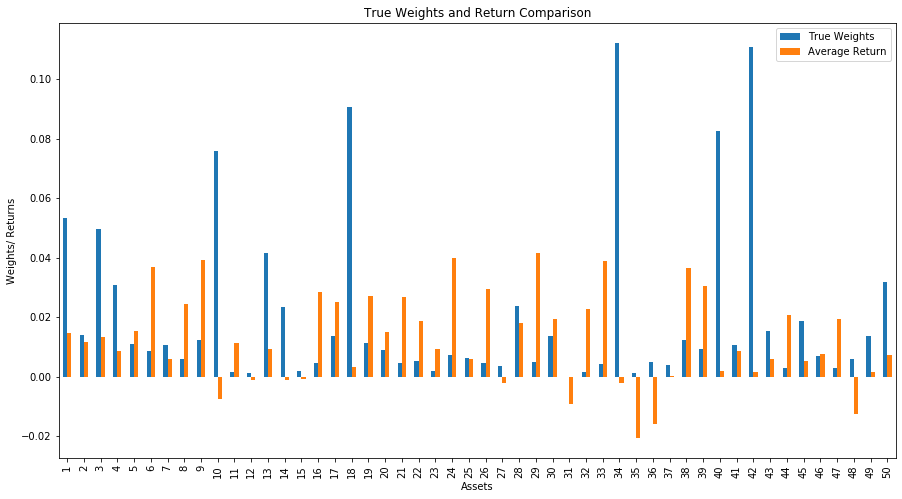

In [8]:
allocation.drop(columns = ["Nested-Cluster Weights","Covexity-Optimized Weights"]).plot.bar(figsize=(15,8))
plt.title("True Weights and Return Comparison")
plt.xlabel("Assets")
plt.ylabel("Weights/ Returns")
plt.show()

**Note**

True weights tend to maximization returns/ minimize risk while striking the balance to diversify portfolio based on "clusters".

In terms of return, True weights trail CVO but from the previous graphs it mimics NCO weightage very closely.